# VBLL Classification

In this notebook, we walk through implementing VBLL classification models, including out of distribution detection.

If you are new to VBLL models, we recommend checking out the regression notebook first!

In [1]:
# !pip install vbll
import vbll

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass

from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
from sklearn import metrics

from tqdm import tqdm
from matplotlib.pyplot import cm


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

We will train a small MLP on MNIST. We use Fashion MNIST as an out of distribution dataset. We will also define a simple visualization function, which we will use later.

In [2]:
mnist_train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

mnist_test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())

mnist_ood_dataset = datasets.FashionMNIST(root='data',
                                    train=False,
                                    transform=transforms.ToTensor(),
                                    download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 39825805.19it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1299530.05it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8556676.99it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10660620.46it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 26421880/26421880 [00:10<00:00, 2552373.19it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270763.31it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4995206.18it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6960759.83it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [26]:
def viz_performance(logs):
    """
    A visualization function that plots losses, accuracies, and out of
    distribution AUROC separately for training and validation sets.

    logs: a dictionary, with keys corresponding to different model evaluations and values
    corresponding to dicts of results.
    """

    # get list of colors
    color = cm.rainbow(np.linspace(0, 1, len(logs)))

    # Plot training and validation losses in separate figures
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    for i, (k, v) in enumerate(logs.items()):
        axes[0].plot(v['train_loss'], label=f'{k} (train)', color=color[i])
        axes[1].plot(v['val_loss'], label=f'{k} (val)', linestyle='--', color=color[i])

    axes[0].set_title('Training Loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    axes[1].set_title('Validation Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()

    plt.show()

    # Plot error rates for training and validation in separate figures
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    for i, (k, v) in enumerate(logs.items()):
        train_error = [1 - x for x in v['train_acc']]
        val_error = [1 - x for x in v['val_acc']]
        axes[0].plot(train_error, label=f'{k} (train)', color=color[i])
        axes[1].plot(val_error, label=f'{k} (val)', linestyle='--', color=color[i])

    axes[0].set_title('Training Error Rate')
    axes[0].set_ylabel('Error Rate')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].semilogy()

    axes[1].set_title('Validation Error Rate')
    axes[1].set_ylabel('Error Rate')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].semilogy()

    plt.show()

    # Plot OOD AUROC for each model in a separate figure
    plt.figure(figsize=(8, 5))
    for i, (k, v) in enumerate(logs.items()):
        plt.plot(v['ood_auroc'], label=k, color=color[i])
    plt.legend()
    plt.ylabel('OOD AUROC')
    plt.xlabel('Epoch')
    plt.title('Out-of-Distribution (OOD) AUROC')
    plt.show()

We will first define a simple MLP (with a standard last layer) as a baseline.

In [3]:
class MLP(nn.Module):
  """
  A standard MLP classification model.

  cfg: a config containing model parameters.
  """
  def __init__(self, cfg):
    super(MLP, self).__init__()

    self.params = nn.ModuleDict({
      'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
      'core': nn.ModuleList([nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES) for i in range(cfg.NUM_LAYERS)]),
      'out_layer': nn.Linear(cfg.HIDDEN_FEATURES, cfg.OUT_FEATURES),
    })
    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS)])
    self.cfg = cfg

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.params['in_layer'](x)

    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x))

    return F.log_softmax(self.params['out_layer'](x), dim=-1)

We have defined a model, and can now write a train loop. In our regression notebook, we write a different train loop for the baseline models and for VBLL models, and highlight the differences. Here, our train function takes are argument in train_cfg indicating whether a model has a VBLL last layer or not. There is a handful of if statements in the code that are different for baseline models and for VBLL models, but the differences are relatively small.

In [4]:
def eval_acc(preds, y):
  map_preds = torch.argmax(preds, dim=1)
  return (map_preds == y).float().mean()

def eval_ood(model, ind_dataloader, ood_dataloader, VBLL=True):
  ind_preds = []
  ood_preds = []

  def get_score(out):
    if VBLL:
      score = out.ood_scores.detach().cpu().numpy()
    else:
      score = torch.max(out, dim=-1)[0].detach().cpu().numpy()
    return score

  for i, (x, y) in enumerate(ind_dataloader):
    x = x.to(device)
    out = model(x)
    ind_preds = np.concatenate((ind_preds, get_score(out)))

  for i, (x, y) in enumerate(ood_dataloader):
    x = x.to(device)
    out = model(x)
    ood_preds = np.concatenate((ood_preds, get_score(out)))

  labels = np.concatenate((np.ones_like(ind_preds)+1, np.ones_like(ind_preds)))
  scores = np.concatenate((ind_preds, ood_preds))
  fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=2)
  return metrics.auc(fpr, tpr)


def train(model, train_cfg):
  """Train a standard classification model with either standard or VBLL models.
  """

  if train_cfg.VBLL:
    # for VBLL models, set weight decay to zero on last layer
    param_list = [
        {'params': model.params.in_layer.parameters(), 'weight_decay': train_cfg.WD},
        {'params': model.params.core.parameters(), 'weight_decay': train_cfg.WD},
        {'params': model.params.out_layer.parameters(), 'weight_decay': 0.}
    ]
  else:
    param_list = model.parameters()
    loss_fn = nn.CrossEntropyLoss() # define loss function only for non-VBLL model

  optimizer = train_cfg.OPT(param_list,
                            lr=train_cfg.LR,
                            weight_decay=train_cfg.WD)

  dataloader = DataLoader(mnist_train_dataset, batch_size = train_cfg.BATCH_SIZE, shuffle=True)
  val_dataloader = DataLoader(mnist_test_dataset, batch_size = train_cfg.BATCH_SIZE, shuffle=True)
  ood_dataloader = DataLoader(mnist_ood_dataset, batch_size = train_cfg.BATCH_SIZE, shuffle=True)

  output_metrics = {
      'train_loss': [],
      'val_loss': [],
      'train_acc': [],
      'val_acc': [],
      'ood_auroc': []
  }

  for epoch in range(train_cfg.NUM_EPOCHS):
    model.train()
    running_loss = []
    running_acc = []

    for train_step, data in enumerate(dataloader):
      optimizer.zero_grad()
      x = data[0].to(device)
      y = data[1].to(device)

      out = model(x)
      if train_cfg.VBLL:
        loss = out.train_loss_fn(y)
        probs = out.predictive.probs
        acc = eval_acc(probs, y).item()
      else:
        loss = loss_fn(out, y)
        acc = eval_acc(out, y).item()

      running_loss.append(loss.item())
      running_acc.append(acc)

      loss.backward()
      optimizer.step()

    output_metrics['train_loss'].append(np.mean(running_loss))
    output_metrics['train_acc'].append(np.mean(running_acc))

    if epoch % train_cfg.VAL_FREQ == 0:
      running_val_loss = []
      running_val_acc = []

      with torch.no_grad():
        model.eval()
        for test_step, data in enumerate(val_dataloader):
          x = data[0].to(device)
          y = data[1].to(device)

          out = model(x)
          if train_cfg.VBLL:
            loss = out.val_loss_fn(y)
            probs = out.predictive.probs
            acc = eval_acc(probs, y).item()
          else:
            loss = loss_fn(out, y)
            acc = eval_acc(out, y).item()

          running_val_loss.append(loss.item())
          running_val_acc.append(acc)

        output_metrics['val_loss'].append(np.mean(running_val_loss))
        output_metrics['val_acc'].append(np.mean(running_val_acc))
      output_metrics['ood_auroc'].append(eval_ood(model, val_dataloader, ood_dataloader, VBLL=train_cfg.VBLL))
      print('Epoch: {:2d}, train loss: {:4.4f}'.format(epoch, np.mean(running_loss)))
      print('Epoch: {:2d}, valid loss: {:4.4f}'.format(epoch, np.mean(np.mean(running_val_loss))))
  return output_metrics

outputs = {}

We can now train a baseline MLP:

In [5]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

class train_cfg:
  NUM_EPOCHS = 30
  BATCH_SIZE = 512
  LR = 1e-3
  WD = 1e-4
  OPT = torch.optim.AdamW
  CLIP_VAL = 1
  VAL_FREQ = 1
  VBLL = False

class cfg:
  IN_FEATURES = 784
  HIDDEN_FEATURES = 128
  OUT_FEATURES = 10
  NUM_LAYERS = 2

model = MLP(cfg()).to(device)
outputs['MLP'] = train(model, train_cfg())

Epoch:  0, train loss: 0.6091
Epoch:  0, valid loss: 0.2648
Epoch:  1, train loss: 0.2453
Epoch:  1, valid loss: 0.2131
Epoch:  2, train loss: 0.1976
Epoch:  2, valid loss: 0.1784
Epoch:  3, train loss: 0.1614
Epoch:  3, valid loss: 0.1497
Epoch:  4, train loss: 0.1373
Epoch:  4, valid loss: 0.1279
Epoch:  5, train loss: 0.1177
Epoch:  5, valid loss: 0.1192
Epoch:  6, train loss: 0.1020
Epoch:  6, valid loss: 0.1090
Epoch:  7, train loss: 0.0903
Epoch:  7, valid loss: 0.1041
Epoch:  8, train loss: 0.0808
Epoch:  8, valid loss: 0.0978
Epoch:  9, train loss: 0.0729
Epoch:  9, valid loss: 0.0929
Epoch: 10, train loss: 0.0644
Epoch: 10, valid loss: 0.0875
Epoch: 11, train loss: 0.0592
Epoch: 11, valid loss: 0.0947
Epoch: 12, train loss: 0.0535
Epoch: 12, valid loss: 0.0909
Epoch: 13, train loss: 0.0485
Epoch: 13, valid loss: 0.0900
Epoch: 14, train loss: 0.0421
Epoch: 14, valid loss: 0.0847
Epoch: 15, train loss: 0.0388
Epoch: 15, valid loss: 0.0870
Epoch: 16, train loss: 0.0355
Epoch: 16,

Now, let's define a VBLL model. Note that the only difference is the out_layer switching from a linear layer to a VBLLClassificationD layer.

We also no longer need to include an output softmax, since that is included in the VBLL classification layer.

In [6]:
class DiscVBLLMLP(nn.Module):
  def __init__(self, cfg):
    super(DiscVBLLMLP, self).__init__()

    self.params = nn.ModuleDict({
      'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
      'core': nn.ModuleList([nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES) for i in range(cfg.NUM_LAYERS)]),
      'out_layer': vbll.DiscClassification(cfg.HIDDEN_FEATURES, cfg.OUT_FEATURES, cfg.REG_WEIGHT, parameterization = cfg.PARAM, return_ood=cfg.RETURN_OOD, prior_scale=cfg.PRIOR_SCALE),
    })
    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS)])
    self.cfg = cfg

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.params['in_layer'](x)

    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x))

    return self.params['out_layer'](x)

In [7]:
class train_cfg:
  NUM_EPOCHS = 30
  BATCH_SIZE = 512
  LR = 3e-3
  WD = 1e-4
  OPT = torch.optim.AdamW
  CLIP_VAL = 1
  VAL_FREQ = 1
  VBLL = True

class cfg:
    IN_FEATURES = 784
    HIDDEN_FEATURES = 128
    OUT_FEATURES = 10
    NUM_LAYERS = 2
    REG_WEIGHT = 1./mnist_train_dataset.__len__()
    PARAM = 'diagonal'
    RETURN_OOD = True
    PRIOR_SCALE = 1.

disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
outputs['DiscVBLL'] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 0.6937
Epoch:  0, valid loss: 0.2682
Epoch:  1, train loss: 0.4149
Epoch:  1, valid loss: 0.2020
Epoch:  2, train loss: 0.3308
Epoch:  2, valid loss: 0.2255
Epoch:  3, train loss: 0.2690
Epoch:  3, valid loss: 0.1439
Epoch:  4, train loss: 0.2318
Epoch:  4, valid loss: 0.1191
Epoch:  5, train loss: 0.2145
Epoch:  5, valid loss: 0.1400
Epoch:  6, train loss: 0.2033
Epoch:  6, valid loss: 0.1322
Epoch:  7, train loss: 0.1999
Epoch:  7, valid loss: 0.1229
Epoch:  8, train loss: 0.1753
Epoch:  8, valid loss: 0.1192
Epoch:  9, train loss: 0.1729
Epoch:  9, valid loss: 0.1375
Epoch: 10, train loss: 0.1649
Epoch: 10, valid loss: 0.1128
Epoch: 11, train loss: 0.1578
Epoch: 11, valid loss: 0.1222
Epoch: 12, train loss: 0.1562
Epoch: 12, valid loss: 0.1296
Epoch: 13, train loss: 0.1481
Epoch: 13, valid loss: 0.1230
Epoch: 14, train loss: 0.1472
Epoch: 14, valid loss: 0.1145
Epoch: 15, train loss: 0.1459
Epoch: 15, valid loss: 0.1398
Epoch: 16, train loss: 0.1411
Epoch: 16,

We can also train a VBLL MLP with a Generative VBLL last layer. Note that we are only changing the output layer. We can use the same config.

Note also that the train loss is not directly comparable between the generative and discriminative models.

In [8]:
class GenVBLLMLP(nn.Module):
  def __init__(self, cfg):
    super(GenVBLLMLP, self).__init__()

    self.params = nn.ModuleDict({
      'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
      'core': nn.ModuleList([nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES) for i in range(cfg.NUM_LAYERS)]),
      'out_layer': vbll.GenClassification(cfg.HIDDEN_FEATURES, cfg.OUT_FEATURES, cfg.REG_WEIGHT, parameterization = cfg.PARAM, return_ood=cfg.RETURN_OOD, prior_scale=cfg.PRIOR_SCALE),
    })
    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS)])
    self.cfg = cfg

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.params['in_layer'](x)

    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x))

    return self.params['out_layer'](x)

In [9]:
gen_vbll_model = GenVBLLMLP(cfg()).to(device)
outputs['GenVBLL'] = train(gen_vbll_model, train_cfg())

Epoch:  0, train loss: 937.1906
Epoch:  0, valid loss: 1.2578
Epoch:  1, train loss: 364.6041
Epoch:  1, valid loss: 0.6017
Epoch:  2, train loss: 197.9758
Epoch:  2, valid loss: 0.4034
Epoch:  3, train loss: 125.1971
Epoch:  3, valid loss: 0.3323
Epoch:  4, train loss: 86.5467
Epoch:  4, valid loss: 0.2935
Epoch:  5, train loss: 63.3841
Epoch:  5, valid loss: 0.2698
Epoch:  6, train loss: 48.3086
Epoch:  6, valid loss: 0.2462
Epoch:  7, train loss: 38.0066
Epoch:  7, valid loss: 0.2252
Epoch:  8, train loss: 30.5874
Epoch:  8, valid loss: 0.2009
Epoch:  9, train loss: 25.0925
Epoch:  9, valid loss: 0.1852
Epoch: 10, train loss: 20.8902
Epoch: 10, valid loss: 0.1820
Epoch: 11, train loss: 17.6330
Epoch: 11, valid loss: 0.1580
Epoch: 12, train loss: 15.0258
Epoch: 12, valid loss: 0.1463
Epoch: 13, train loss: 12.9305
Epoch: 13, valid loss: 0.1385
Epoch: 14, train loss: 11.2150
Epoch: 14, valid loss: 0.1303
Epoch: 15, train loss: 9.7976
Epoch: 15, valid loss: 0.1295
Epoch: 16, train loss

And finally, we can visualize performance of all models.

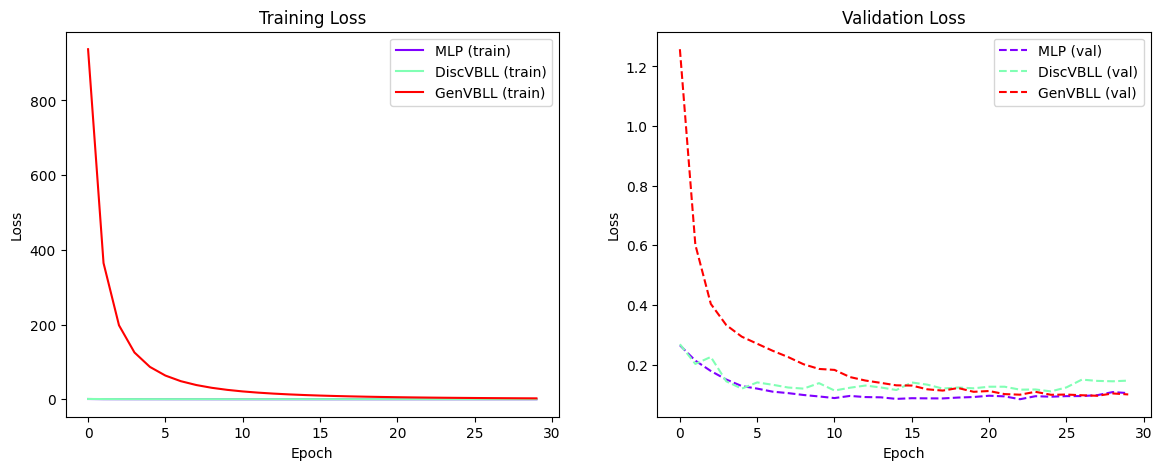

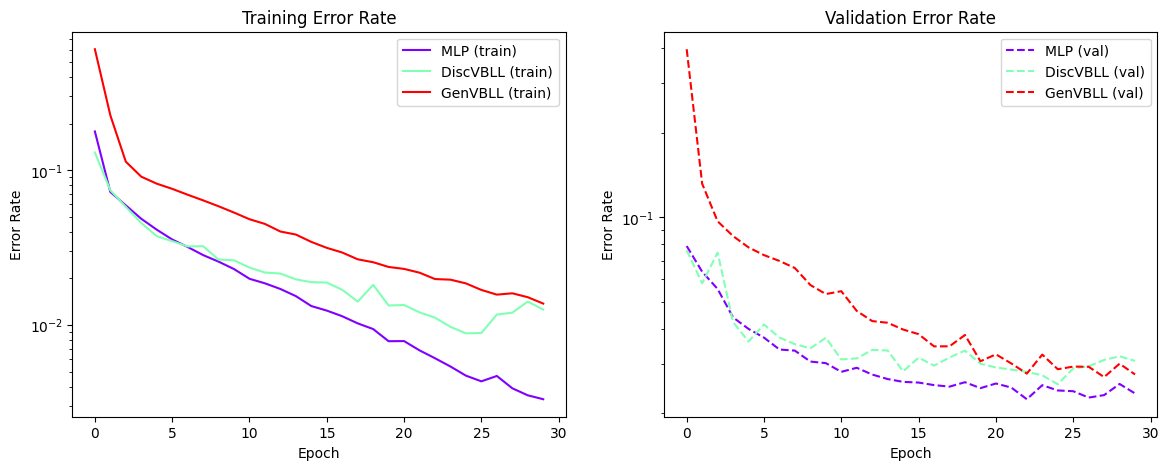

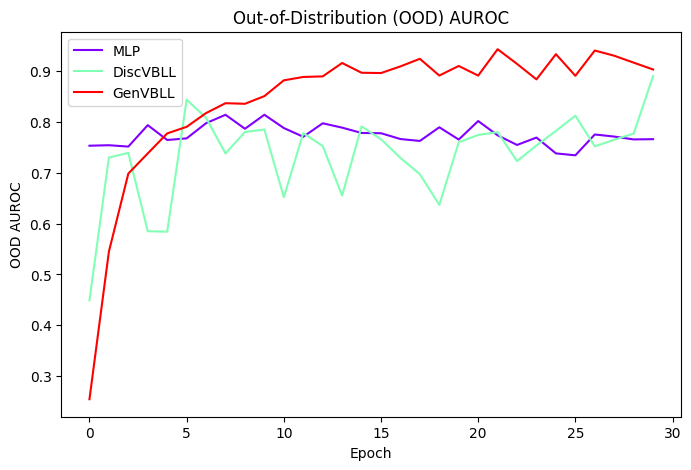

In [16]:
viz_performance(outputs)

## Starting the hyperparameter search

In [29]:
def viz_performance(logs, title):
    """
    A visualization function that plots losses, accuracies, and out of
    distribution AUROC separately for training and validation sets. Each plot will include
    a title that reflects the experimental condition.

    logs: a dictionary, with keys corresponding to different model evaluations and values
    corresponding to dicts of results.
    title: a string that will be included in the title of each plot to describe the experimental condition.
    """

    # get list of colors
    color = cm.rainbow(np.linspace(0, 1, len(logs)))

    # Plot training and validation losses in separate figures
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    for i, (k, v) in enumerate(logs.items()):
        axes[0].plot(v['train_loss'], label=f'{k} (train)', color=color[i])
        axes[1].plot(v['val_loss'], label=f'{k} (val)', linestyle='--', color=color[i])

    axes[0].set_title(f'{title} - Training Loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    axes[1].set_title(f'{title} - Validation Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()

    plt.show()

    # Plot error rates for training and validation in separate figures
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    for i, (k, v) in enumerate(logs.items()):
        train_error = [1 - x for x in v['train_acc']]
        val_error = [1 - x for x in v['val_acc']]
        axes[0].plot(train_error, label=f'{k} (train)', color=color[i])
        axes[1].plot(val_error, label=f'{k} (val)', linestyle='--', color=color[i])

    axes[0].set_title(f'{title} - Training Error Rate')
    axes[0].set_ylabel('Error Rate')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].semilogy()

    axes[1].set_title(f'{title} - Validation Error Rate')
    axes[1].set_ylabel('Error Rate')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].semilogy()

    plt.show()

    # Plot OOD AUROC for each model in a separate figure
    plt.figure(figsize=(8, 5))
    for i, (k, v) in enumerate(logs.items()):
        plt.plot(v['ood_auroc'], label=k, color=color[i])
    plt.legend()
    plt.ylabel('OOD AUROC')
    plt.xlabel('Epoch')
    plt.title(f'{title} - Out-of-Distribution (OOD) AUROC')
    plt.show()

Epoch:  0, train loss: 0.6074
Epoch:  0, valid loss: 0.2662
Epoch:  1, train loss: 0.2428
Epoch:  1, valid loss: 0.2125
Epoch:  2, train loss: 0.1966
Epoch:  2, valid loss: 0.1706
Epoch:  3, train loss: 0.1625
Epoch:  3, valid loss: 0.1559
Epoch:  4, train loss: 0.1384
Epoch:  4, valid loss: 0.1327
Epoch:  5, train loss: 0.1192
Epoch:  5, valid loss: 0.1213
Epoch:  6, train loss: 0.1035
Epoch:  6, valid loss: 0.1229
Epoch:  7, train loss: 0.0912
Epoch:  7, valid loss: 0.1113
Epoch:  8, train loss: 0.0823
Epoch:  8, valid loss: 0.1086
Epoch:  9, train loss: 0.0757
Epoch:  9, valid loss: 0.1020
Epoch: 10, train loss: 0.0647
Epoch: 10, valid loss: 0.0948
Epoch: 11, train loss: 0.0588
Epoch: 11, valid loss: 0.0970
Epoch: 12, train loss: 0.0541
Epoch: 12, valid loss: 0.0893
Epoch: 13, train loss: 0.0474
Epoch: 13, valid loss: 0.0877
Epoch: 14, train loss: 0.0421
Epoch: 14, valid loss: 0.0893
Epoch: 15, train loss: 0.0392
Epoch: 15, valid loss: 0.0801
Epoch: 16, train loss: 0.0339
Epoch: 16,

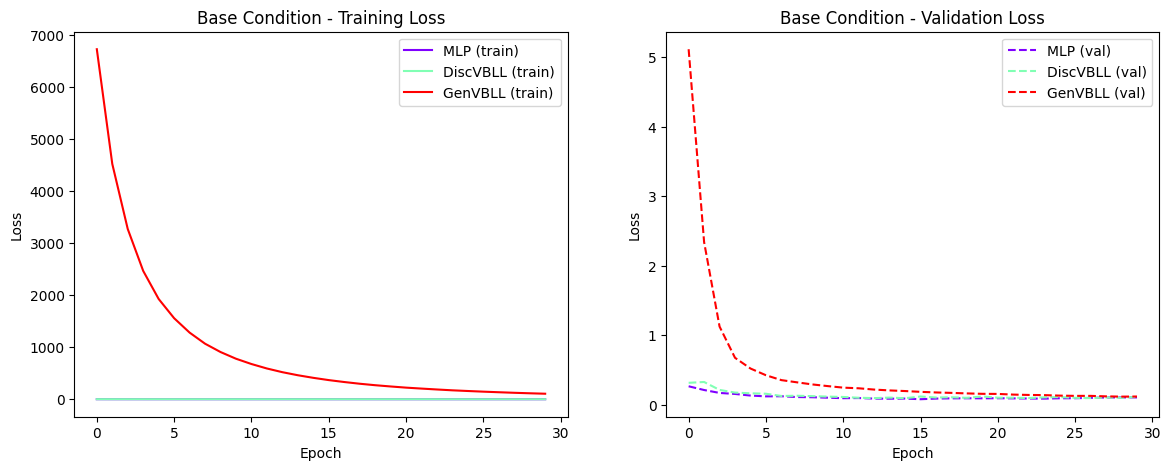

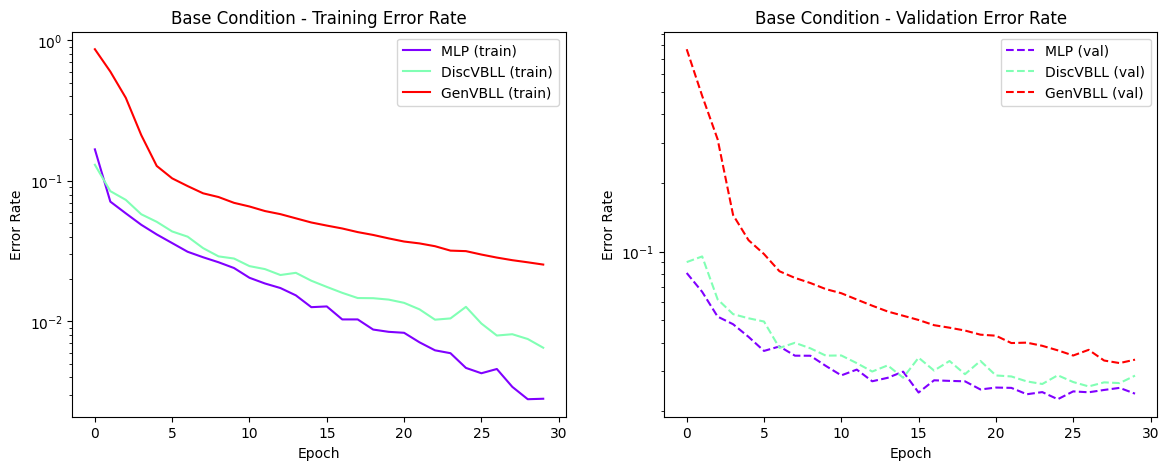

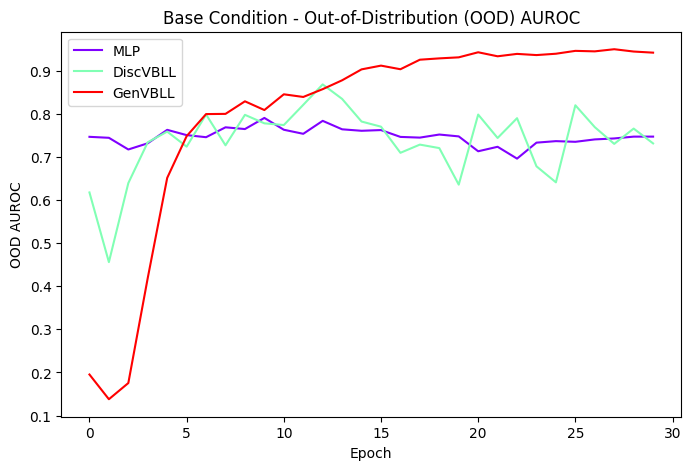

Epoch:  0, train loss: 0.3618
Epoch:  0, valid loss: 0.1840
Epoch:  1, train loss: 0.1629
Epoch:  1, valid loss: 0.1720
Epoch:  2, train loss: 0.1320
Epoch:  2, valid loss: 0.1443
Epoch:  3, train loss: 0.1172
Epoch:  3, valid loss: 0.1247
Epoch:  4, train loss: 0.1116
Epoch:  4, valid loss: 0.1130
Epoch:  5, train loss: 0.1000
Epoch:  5, valid loss: 0.1598
Epoch:  6, train loss: 0.0984
Epoch:  6, valid loss: 0.1744
Epoch:  7, train loss: 0.1067
Epoch:  7, valid loss: 0.1600
Epoch:  8, train loss: 0.0957
Epoch:  8, valid loss: 0.1378
Epoch:  9, train loss: 0.0931
Epoch:  9, valid loss: 0.1687
Epoch: 10, train loss: 0.1001
Epoch: 10, valid loss: 0.1871
Epoch: 11, train loss: 0.0935
Epoch: 11, valid loss: 0.1840
Epoch: 12, train loss: 0.1047
Epoch: 12, valid loss: 0.1867
Epoch: 13, train loss: 0.1009
Epoch: 13, valid loss: 0.1565
Epoch: 14, train loss: 0.0974
Epoch: 14, valid loss: 0.1647
Epoch: 15, train loss: 0.0839
Epoch: 15, valid loss: 0.1637
Epoch: 16, train loss: 0.0922
Epoch: 16,

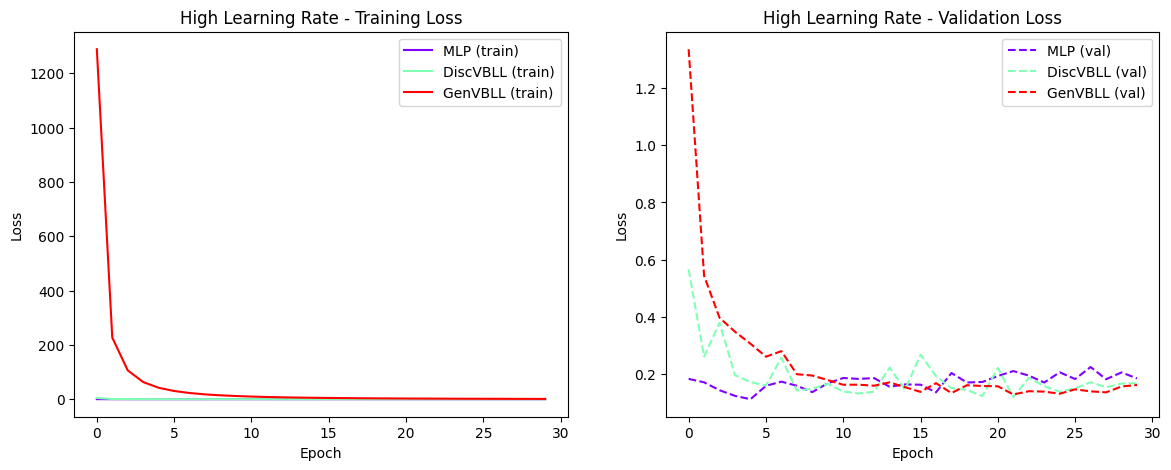

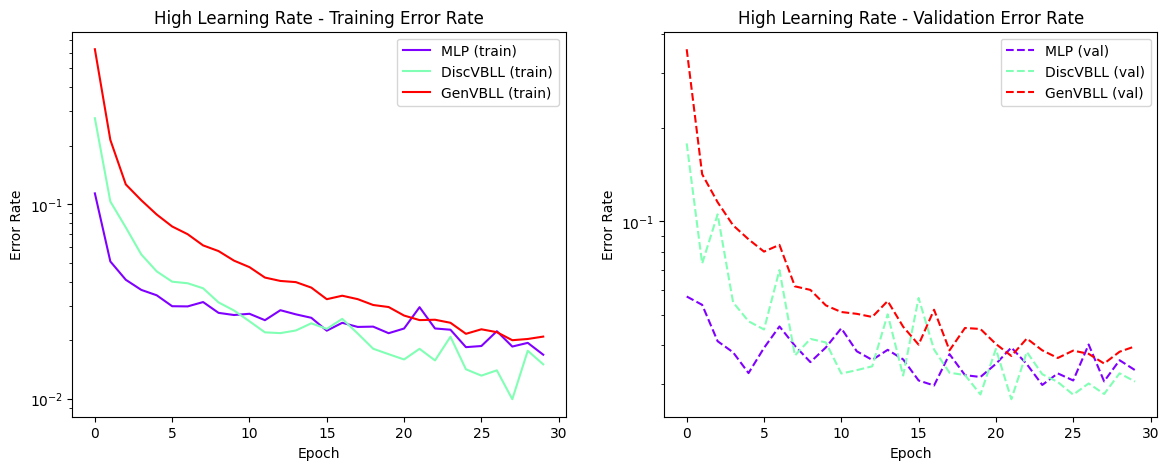

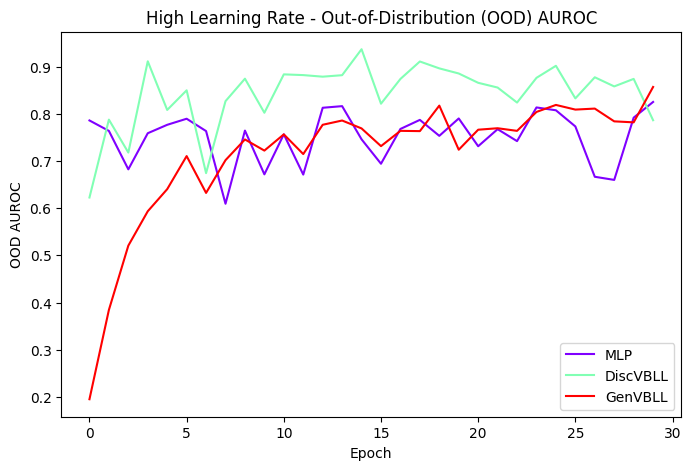

Epoch:  0, train loss: 0.4608
Epoch:  0, valid loss: 0.2403
Epoch:  1, train loss: 0.2155
Epoch:  1, valid loss: 0.1734
Epoch:  2, train loss: 0.1616
Epoch:  2, valid loss: 0.1498
Epoch:  3, train loss: 0.1326
Epoch:  3, valid loss: 0.1241
Epoch:  4, train loss: 0.1102
Epoch:  4, valid loss: 0.1200
Epoch:  5, train loss: 0.0940
Epoch:  5, valid loss: 0.1086
Epoch:  6, train loss: 0.0801
Epoch:  6, valid loss: 0.0937
Epoch:  7, train loss: 0.0710
Epoch:  7, valid loss: 0.0913
Epoch:  8, train loss: 0.0618
Epoch:  8, valid loss: 0.0959
Epoch:  9, train loss: 0.0543
Epoch:  9, valid loss: 0.0808
Epoch: 10, train loss: 0.0478
Epoch: 10, valid loss: 0.0864
Epoch: 11, train loss: 0.0427
Epoch: 11, valid loss: 0.0886
Epoch: 12, train loss: 0.0363
Epoch: 12, valid loss: 0.0844
Epoch: 13, train loss: 0.0342
Epoch: 13, valid loss: 0.1049
Epoch: 14, train loss: 0.0293
Epoch: 14, valid loss: 0.0775
Epoch: 15, train loss: 0.0286
Epoch: 15, valid loss: 0.0874
Epoch: 16, train loss: 0.0240
Epoch: 16,

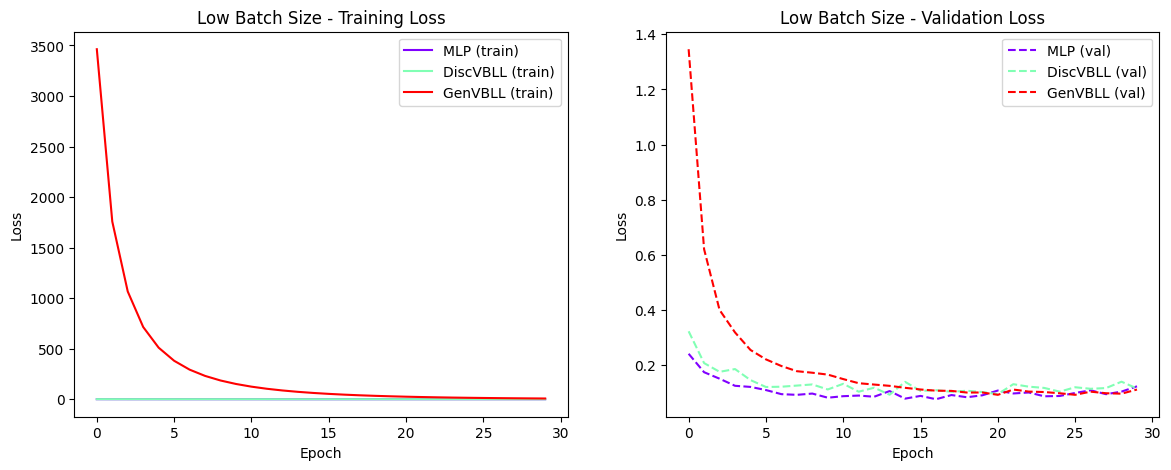

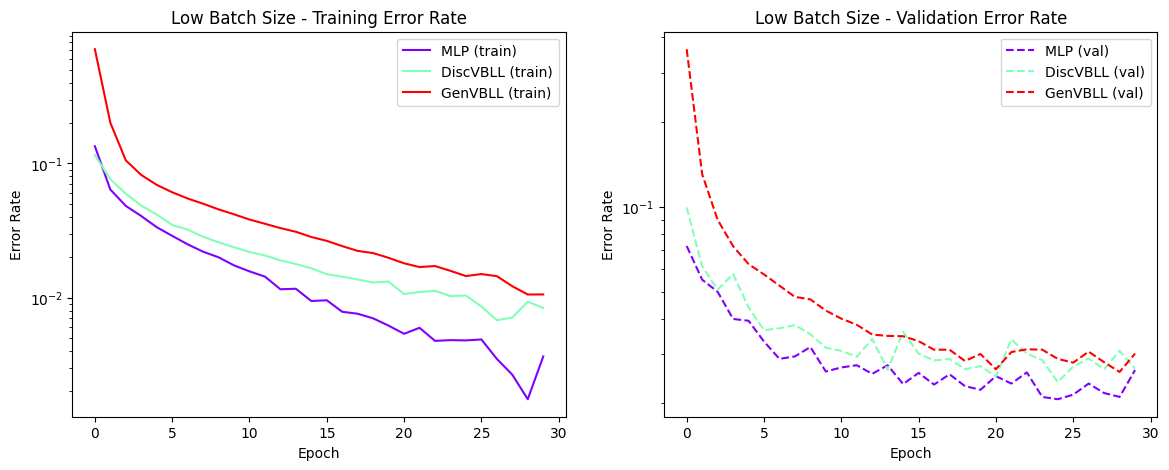

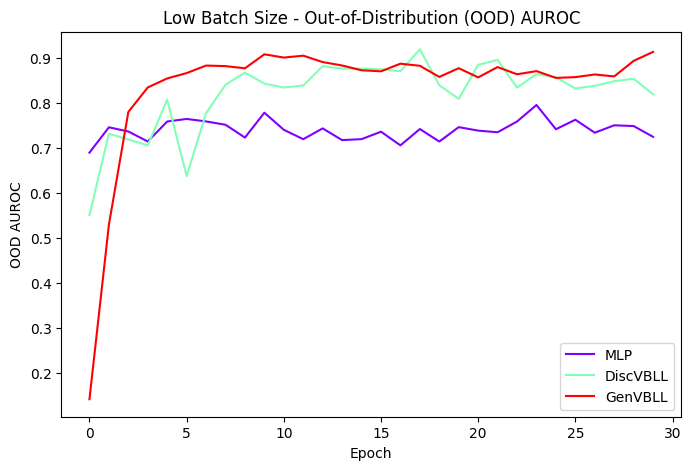

Epoch:  0, train loss: 0.8578
Epoch:  0, valid loss: 0.3123
Epoch:  1, train loss: 0.2832
Epoch:  1, valid loss: 0.2453
Epoch:  2, train loss: 0.2334
Epoch:  2, valid loss: 0.2152
Epoch:  3, train loss: 0.1990
Epoch:  3, valid loss: 0.1809
Epoch:  4, train loss: 0.1713
Epoch:  4, valid loss: 0.1616
Epoch:  5, train loss: 0.1504
Epoch:  5, valid loss: 0.1464
Epoch:  6, train loss: 0.1358
Epoch:  6, valid loss: 0.1402
Epoch:  7, train loss: 0.1228
Epoch:  7, valid loss: 0.1299
Epoch:  8, train loss: 0.1116
Epoch:  8, valid loss: 0.1294
Epoch:  9, train loss: 0.1006
Epoch:  9, valid loss: 0.1111
Epoch: 10, train loss: 0.0905
Epoch: 10, valid loss: 0.1091
Epoch: 11, train loss: 0.0828
Epoch: 11, valid loss: 0.1032
Epoch: 12, train loss: 0.0750
Epoch: 12, valid loss: 0.0950
Epoch: 13, train loss: 0.0700
Epoch: 13, valid loss: 0.0948
Epoch: 14, train loss: 0.0650
Epoch: 14, valid loss: 0.0986
Epoch: 15, train loss: 0.0604
Epoch: 15, valid loss: 0.0897
Epoch: 16, train loss: 0.0546
Epoch: 16,

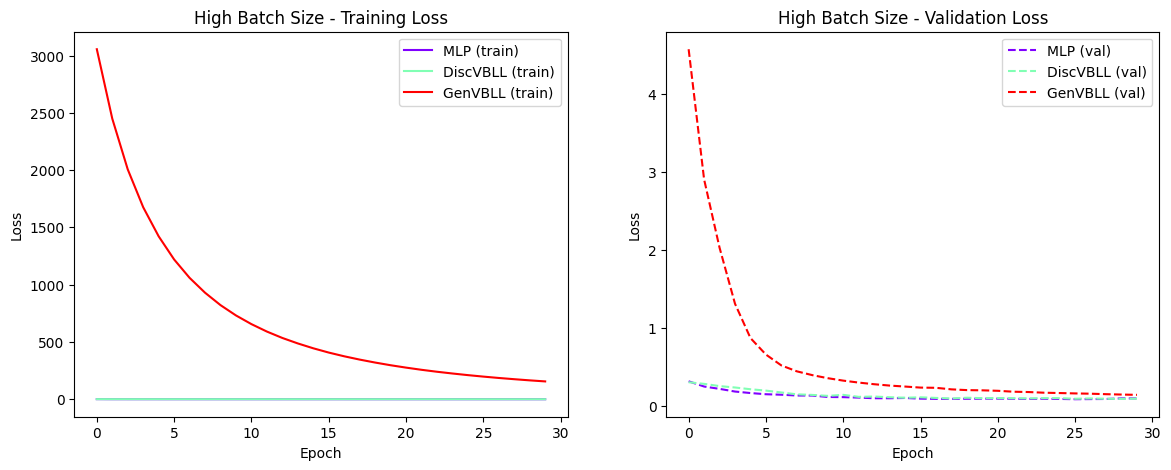

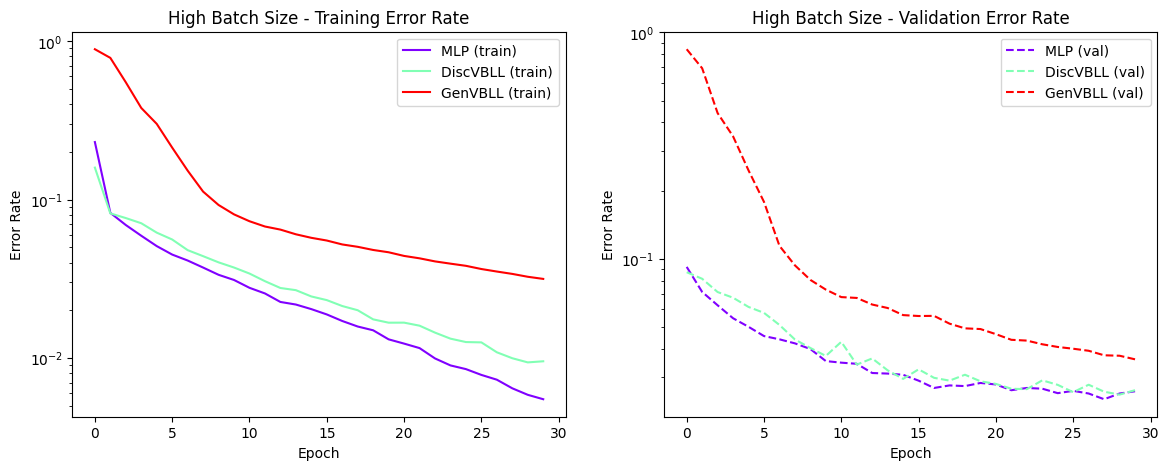

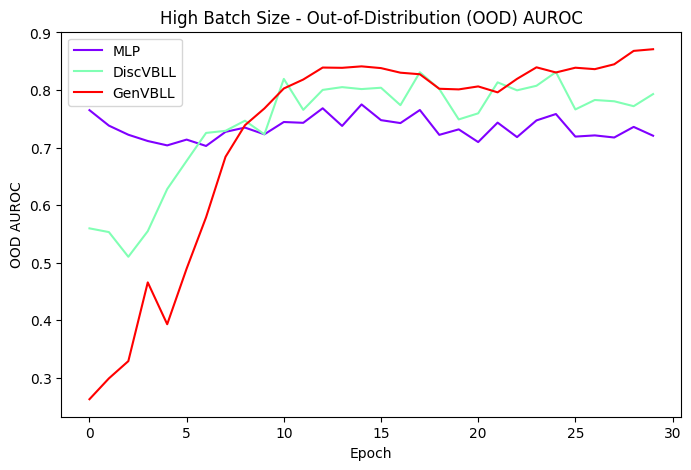

Epoch:  0, train loss: 0.5912
Epoch:  0, valid loss: 0.2647
Epoch:  1, train loss: 0.2428
Epoch:  1, valid loss: 0.2180
Epoch:  2, train loss: 0.1929
Epoch:  2, valid loss: 0.1694
Epoch:  3, train loss: 0.1572
Epoch:  3, valid loss: 0.1503
Epoch:  4, train loss: 0.1353
Epoch:  4, valid loss: 0.1353
Epoch:  5, train loss: 0.1176
Epoch:  5, valid loss: 0.1264
Epoch:  6, train loss: 0.1043
Epoch:  6, valid loss: 0.1128
Epoch:  7, train loss: 0.0915
Epoch:  7, valid loss: 0.1038
Epoch:  8, train loss: 0.0810
Epoch:  8, valid loss: 0.0971
Epoch:  9, train loss: 0.0711
Epoch:  9, valid loss: 0.0982
Epoch: 10, train loss: 0.0646
Epoch: 10, valid loss: 0.1032
Epoch: 11, train loss: 0.0589
Epoch: 11, valid loss: 0.0957
Epoch: 12, train loss: 0.0523
Epoch: 12, valid loss: 0.0972
Epoch: 13, train loss: 0.0489
Epoch: 13, valid loss: 0.0902
Epoch: 14, train loss: 0.0423
Epoch: 14, valid loss: 0.0942
Epoch: 15, train loss: 0.0374
Epoch: 15, valid loss: 0.0908
Epoch: 16, train loss: 0.0343
Epoch: 16,

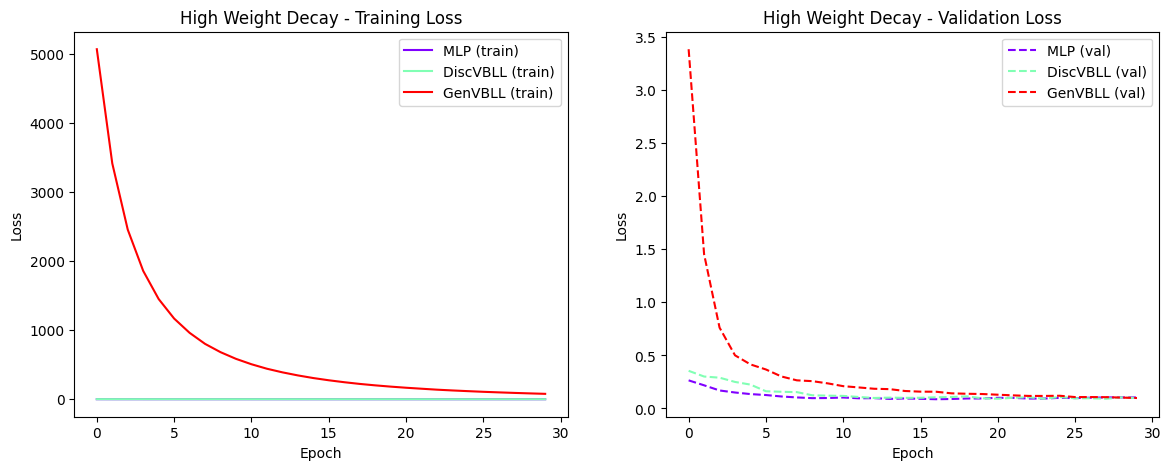

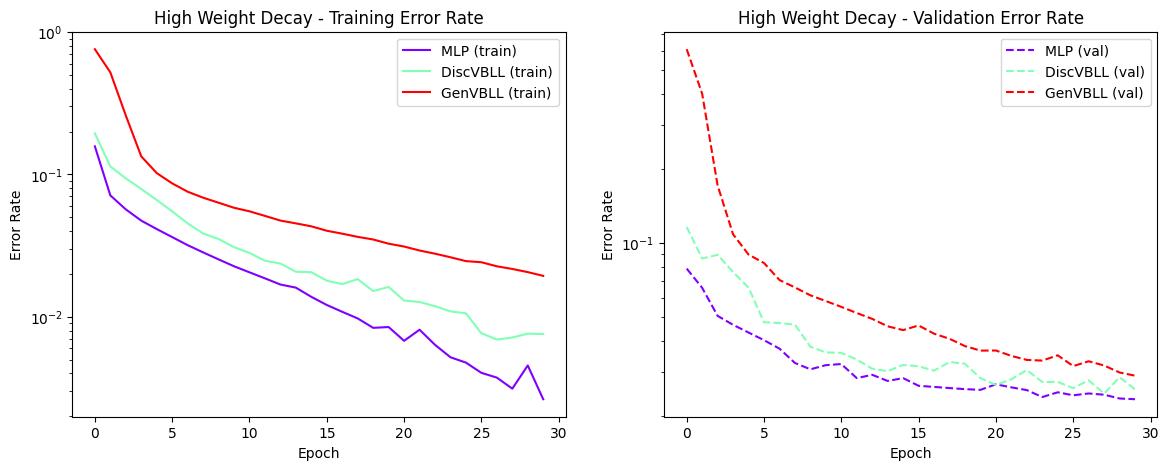

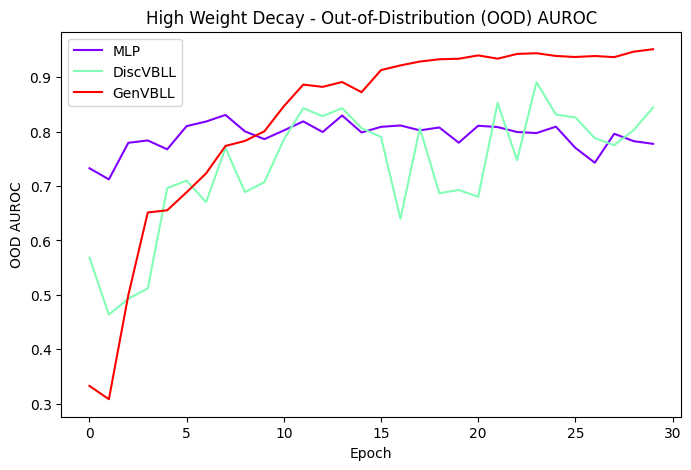

Epoch:  0, train loss: 0.5907
Epoch:  0, valid loss: 0.2686
Epoch:  1, train loss: 0.2435
Epoch:  1, valid loss: 0.2160
Epoch:  2, train loss: 0.1999
Epoch:  2, valid loss: 0.1819
Epoch:  3, train loss: 0.1657
Epoch:  3, valid loss: 0.1524
Epoch:  4, train loss: 0.1387
Epoch:  4, valid loss: 0.1363
Epoch:  5, train loss: 0.1200
Epoch:  5, valid loss: 0.1304
Epoch:  6, train loss: 0.1055
Epoch:  6, valid loss: 0.1144
Epoch:  7, train loss: 0.0963
Epoch:  7, valid loss: 0.1141
Epoch:  8, train loss: 0.0835
Epoch:  8, valid loss: 0.1004
Epoch:  9, train loss: 0.0741
Epoch:  9, valid loss: 0.1010
Epoch: 10, train loss: 0.0677
Epoch: 10, valid loss: 0.0941
Epoch: 11, train loss: 0.0607
Epoch: 11, valid loss: 0.0886
Epoch: 12, train loss: 0.0531
Epoch: 12, valid loss: 0.0880
Epoch: 13, train loss: 0.0486
Epoch: 13, valid loss: 0.0892
Epoch: 14, train loss: 0.0430
Epoch: 14, valid loss: 0.0820
Epoch: 15, train loss: 0.0399
Epoch: 15, valid loss: 0.0874
Epoch: 16, train loss: 0.0375
Epoch: 16,

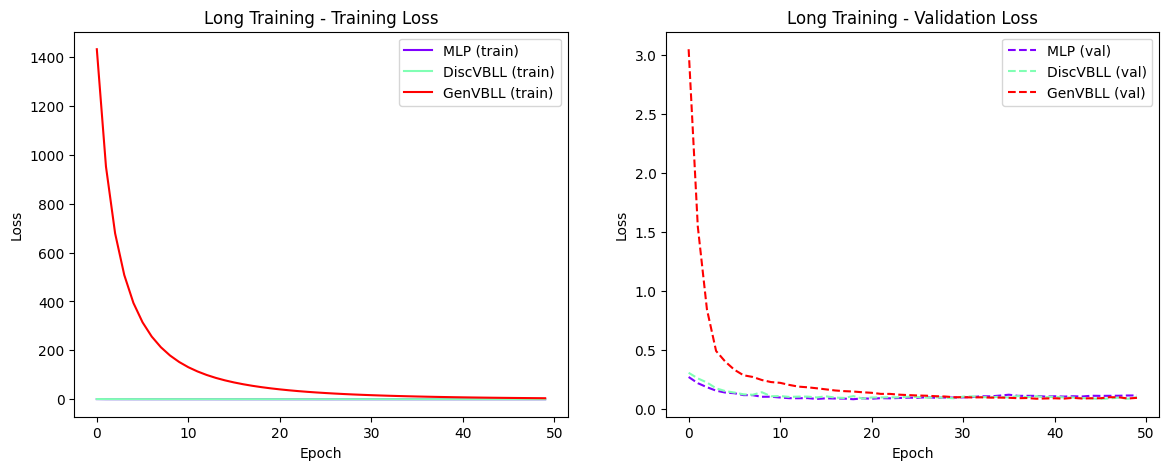

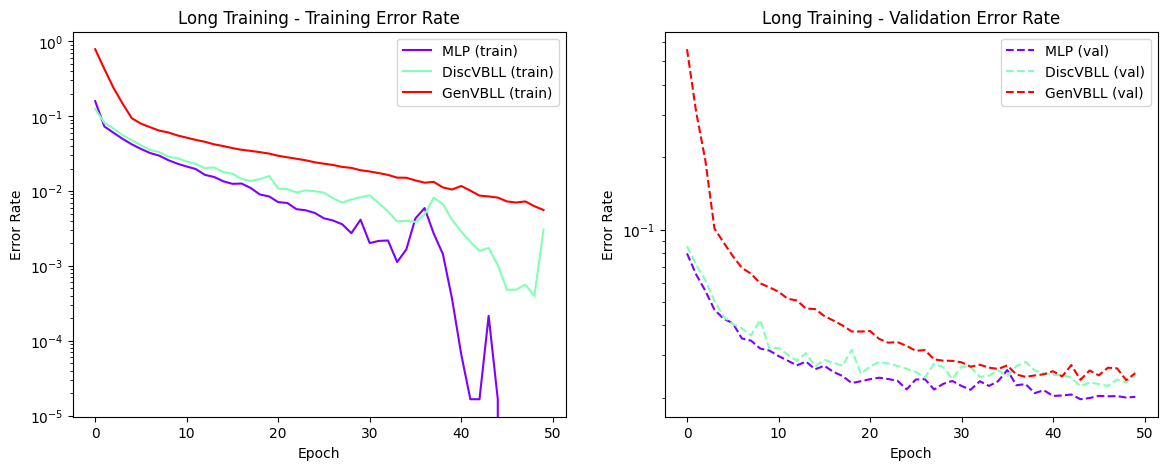

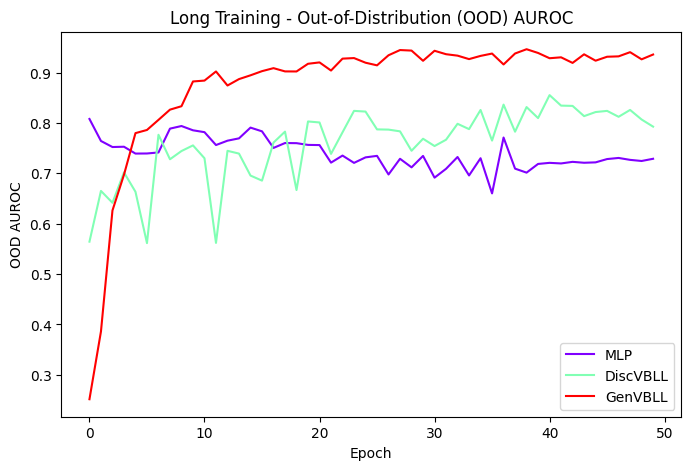

In [30]:

# 기본 모델 구성 및 학습 설정
class cfg:
    IN_FEATURES = 784
    HIDDEN_FEATURES = 128
    OUT_FEATURES = 10
    NUM_LAYERS = 2

class train_cfg:
    NUM_EPOCHS = 30
    BATCH_SIZE = 512
    LR = 1e-3
    WD = 1e-4
    OPT = torch.optim.AdamW
    CLIP_VAL = 1
    VAL_FREQ = 1
    VBLL = False

# 실험 조건을 반복적으로 적용하고 실행하는 함수
def setup_and_run_experiments():
    conditions = [
        ("Base Condition", 1e-3, 512, 1e-4, 30),
        ("High Learning Rate", 1e-2, 512, 1e-4, 30),
        ("Low Batch Size", 1e-3, 256, 1e-4, 30),
        ("High Batch Size", 1e-3, 1024, 1e-4, 30),
        ("High Weight Decay", 1e-3, 512, 1e-3, 30),
        ("Long Training", 1e-3, 512, 1e-4, 50)
    ]

    for condition_name, lr, batch_size, wd, epochs in conditions:
        # 모델 설정 적용
        train_config = train_cfg()
        train_config.LR = lr
        train_config.BATCH_SIZE = batch_size
        train_config.WD = wd
        train_config.NUM_EPOCHS = epochs

        # 디바이스 설정
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # MLP 모델 학습
        mlp_model = MLP(cfg()).to(device)
        outputs = {'MLP': train(mlp_model, train_config)}

        # DiscVBLL 모델 학습
        train_config.VBLL = True  # VBLL 모델에 대한 플래그 설정
        vbll_cfg = cfg()
        vbll_cfg.REG_WEIGHT = 1. / mnist_train_dataset.__len__()
        vbll_cfg.PARAM = 'diagonal'
        vbll_cfg.RETURN_OOD = True
        vbll_cfg.PRIOR_SCALE = 1.0
        disc_vbll_model = DiscVBLLMLP(vbll_cfg).to(device)
        outputs['DiscVBLL'] = train(disc_vbll_model, train_config)

        # GenVBLL 모델 학습
        gen_vbll_model = GenVBLLMLP(vbll_cfg).to(device)
        outputs['GenVBLL'] = train(gen_vbll_model, train_config)

        # 결과 시각화
        viz_performance(outputs, condition_name)

# 실험 실행
setup_and_run_experiments()
